# imports

In [ ]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.gridspec as gridspec
import math
#import data_transforations as data_tr

import joblib
from sklearn.preprocessing import StandardScaler


In [5]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/NearFuture/"

## Models

In [6]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from scipy.stats import loguniform


## Scoring

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Functions

In [8]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

In [9]:
#functions for plotting continous features
def plot_histogram_boxplot_kde(data, title="Data Distribution", x_label="Value"):
    """
    Generates a combined plot showing a histogram with KDE, a box plot,
    and summary statistics.

    Args:
        data (array-like): A list, numpy array, or pandas Series of numerical data.
        title (str, optional): The main title for the plot. Defaults to "Data Distribution".
        x_label (str, optional): The label for the x-axis. Defaults to "Value".
    """
    # Convert data to a pandas Series to easily handle potential NaNs and calculations
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Drop NaN values to avoid errors in plotting and calculations
    print('Number of NaN values to be dropped: ',data.isnull().sum())
    data = data.dropna()

    if data.empty:
        print("Warning: Input data is empty or contains only NaN values. Cannot generate plot.")
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics for display
    stats_text = (
        f"Statistics:\n"
        f"-----------\n"
        f"Count: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Set up the plot layout ---
    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    # Define the grid layout: 2 rows, 2 columns.
    # Top row for box plot, bottom row for histogram.
    # Right column for text.
    # Adjust width/height ratios for better spacing.
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           figure=fig, wspace=0.1, hspace=0.05) # Reduced space

    # Create axes for each part of the plot
    ax_hist = fig.add_subplot(gs[1, 0])        # Histogram/KDE at bottom-left
    ax_box = fig.add_subplot(gs[0, 0], sharex=ax_hist) # Box plot at top-left, sharing x-axis
    ax_text = fig.add_subplot(gs[:, 1])        # Text box spanning both rows on the right

    # --- Plot the data ---
    # 1. Histogram and KDE plot (using seaborn for convenience)
    #    'bins="auto"' lets seaborn/numpy choose a suitable number of bins.
    #    'kde=True' adds the Kernel Density Estimate.
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Density")

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1.5, label=f'Median ({median_val:.2f})')
    ax_hist.legend(loc='upper right') # Add legend to histogram plot

    # 2. Box plot
    #    Use seaborn's boxplot for consistency.
    #    'orient='h'' makes it horizontal.
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('') # Remove x-label as it's shared with histogram
    # Remove y-ticks and labels from boxplot for cleaner look
    ax_box.set_yticks([])
    ax_box.set_ylabel('') # Remove y-label

    # Remove ticks and labels from the top x-axis of the box plot
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False) # Remove ticks

    # 3. Statistics Text Box
    ax_text.axis('off') # Turn off the axis lines and ticks
    # Place the text in the center of the text axes
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))

    # --- Final Touches ---
    fig.suptitle(title, fontsize=16) # Add overall title
    # Adjust layout to prevent labels/titles overlapping
    # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    fig.subplots_adjust(top=0.92) # Adjust top margin for suptitle

#--------------------------------------------------------------------------------------------------------------------------------------------

# --- Helper function to plot distribution for a single category ---
# This adapts the logic from the previous function to draw on specific axes
def _plot_single_distribution(data, fig, ax,title="Distribution", x_label="Value"):
    """
    Helper function to draw histogram, KDE, box plot, and stats on a given Axes object
    by creating a nested GridSpec.

    Args:
        data (pd.Series): Numerical data for a single category (NaNs already handled).
        fig (matplotlib.figure.Figure): The main figure object.
        ax (matplotlib.axes.Axes): The main Axes object (from the outer grid)
                                   to draw this category's plot within.
        title (str): Title for this specific subplot.
        x_label (str): Label for the x-axis.
    """

    
  
    # Get the SubplotSpec from the parent Axes object
    ss = ax.get_subplotspec()
    # Turn off the axis frame/ticks for the original 'ax' as its space will be managed by the nested GridSpec
    ax.axis('off')

    if data.empty:
        # If data is empty, add text to the original Axes location
        ax.text(0.5, 0.5, "No data for this category",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=10, color='grey')
        ax.set_title(title, fontsize=10) # Set title on the original Axes
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics
    stats_text = (
        f"N: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"StdDev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Create inset axes within the main 'ax' space using its SubplotSpec ---
    gs_inset = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ss, # Use the SubplotSpec here
                                                width_ratios=[4, 1], height_ratios=[1, 4],
                                                wspace=0.05, hspace=0.05)

    # Create the actual Axes using the main figure and the nested GridSpec indices
    ax_hist = fig.add_subplot(gs_inset[1, 0]) # Histogram at bottom-left
    ax_box = fig.add_subplot(gs_inset[0, 0], sharex=ax_hist) # Box plot at top-left
    ax_text = fig.add_subplot(gs_inset[:, 1]) # Text box on the right

    # --- Plot the data ---
    # 1. Histogram and KDE
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label, fontsize=9) # Slightly smaller font for subplot labels
    ax_hist.set_ylabel("Density", fontsize=9)
    ax_hist.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median ({median_val:.2f})')
    ax_hist.legend(fontsize='x-small', loc='upper right') # Smaller legend

    # 2. Box plot
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])
    ax_box.set_ylabel('')
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False)

    # 3. Statistics Text Box
    ax_text.axis('off')
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=8, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))

    # Set the title for the specific subplot (category) on the original Axes container
    ax.set_title(title, fontsize=10)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# --- Main function to create the grid plot ---
def plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions"):
    """
    Generates a grid of distribution plots (hist, KDE, boxplot, stats)
    for numerical data grouped by a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_col (str): The name of the column with numerical data.
        category_col (str): The name of the column with categorical data.
        main_title (str, optional): The main title for the entire figure.
                                    Defaults to "Grouped Distributions".
    """

    if category_col == 'none':
        
        plot_histogram_boxplot_kde(df[value_col], title=f"Distribution of {value_col}", x_label=value_col)

    else:

        # Check if columns exist
        if value_col not in df.columns:
            print(f"Error: Value column '{value_col}' not found in DataFrame.")
            return
        if category_col not in df.columns:
            print(f"Error: Category column '{category_col}' not found in DataFrame.")
            return

        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs in category column
        # Sort categories for consistent plot order
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # --- Determine grid layout ---
        # Aim for a layout that's roughly square
        ncols = math.ceil(math.sqrt(n_categories))
        nrows = math.ceil(n_categories / ncols)

        # --- Create figure and subplots ---
        # Adjust figsize based on grid size for better readability
        # Increased base size slightly for better spacing within subplots
        fig_width = ncols * 5.5
        fig_height = nrows * 4.5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)

        # Flatten axes array for easy iteration
        axes_flat = axes.flatten()

        # --- Plot data for each category ---
        for i, category in enumerate(categories):
            ax = axes_flat[i]
            # Filter data for the current category, dropping NaNs in the value column
            category_data = df[df[category_col] == category][value_col].dropna()

            # Call the helper function to plot on the current axes
            # Pass the main 'fig' object as well
            _plot_single_distribution(category_data, fig, ax, # Pass fig and ax
                                      title=f"{category}", # Simpler title, category name only
                                      x_label=value_col)

        # --- Clean up unused subplots ---
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off') # Hide unused axes

        # --- Final Touches ---
        # Add a more descriptive main title including column names
        full_main_title = f"{main_title}: {value_col} by {category_col}"
        fig.suptitle(full_main_title, fontsize=16, y=1.0) # Adjust title position slightly
        # Use tight_layout first, then adjust spacing if needed
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to prevent overlap and make space for title/labels
        # plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3) # Fine-tune spacing if tight_layout isn't enough

    plt.show()

In [10]:
#bar comparison
def bar_comp(df,category, split):
    
    props=df.groupby(split)[category].value_counts(normalize=True).rename('proportion').reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=props,
        x=category,
        y='proportion',
        hue=split,
        palette='viridis')  
    
    # Set the title and labels for clarity.
    plt.title(f'Proportion of {category} by {split}', fontsize=16)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.legend(title=split)

    # Add annotations to the bars to show the exact proportion.
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout() # Adjust layout to make room for the labels.
    plt.show()





In [11]:
def data_prep(data, model_target):

    data.drop(columns=['Unnamed: 0','reason', 'policy_type', 'has_been_recaptured','securitygroup_id','# claims', 'res_code_QA_sum','res_code_claims_sum', 'res_code_update_sum'], inplace=True)

    #imputing nulls
    fill_values = {
        '1 month ago payment': 'not incepted',
        '2 month ago payment': 'not incepted',
        '3 month ago payment': 'not incepted',
        '4 month ago payment': 'not incepted',
        '5 month ago payment': 'not incepted',
        '6 month ago payment': 'not incepted'}
    # Use the dictionary to fill missing values
    data.fillna(value=fill_values, inplace=True)
    data_info = DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
                  'cover_amount_full':'mean'}
    data_info.imputating_nulls(imp_dict=imp_dict)
    data=data_info.imputed_df
    data['original_premium'] = data['original_premium'].fillna(data['premium'])
    data['prev_premium'] = data['prev_premium'].fillna(data['premium'])

    #creating next month lapse data sets
    if model_target == '1month':
        next_month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation',
           'unemployment rate']].copy()
        

        cat_cols=['education','gender', 'smoker_status', 'sold_socio_economic_class','1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment'
            ]
        next_month_lapse_data=pd.get_dummies(next_month_lapse_data,columns=cat_cols, dtype=int)
        
        features=list(set(next_month_lapse_data.columns).difference({'lapse_flag'}))

        X = next_month_lapse_data[features].copy()
        Y = next_month_lapse_data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test
    
    #creating next 3 months lapses
    elif model_target == '3month':
        next_3month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation',
           'unemployment rate']].copy()
        next_3month_lapse_data['1 month ago payment']=next_3month_lapse_data['4 month ago payment']
        next_3month_lapse_data['2 month ago payment']=next_3month_lapse_data['5 month ago payment']
        next_3month_lapse_data['3 month ago payment']=next_3month_lapse_data['6 month ago payment']
        next_3month_lapse_data.drop(columns=['4 month ago payment', '5 month ago payment', '6 month ago payment'],inplace=True)
        next_3month_lapse_data['* policy duration months'] = next_3month_lapse_data['* policy duration months']-3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary']+3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary'].apply(lambda x: x if x<13 else x%12)

        cat_cols=['education','gender', 'smoker_status', 'sold_socio_economic_class',
           '1 month ago payment', '2 month ago payment', '3 month ago payment'
            ]
        next_3month_lapse_data=pd.get_dummies(next_3month_lapse_data,columns=cat_cols, dtype=int)

        features=list(set(next_3month_lapse_data.columns).difference({'lapse_flag'}))
        X = next_3month_lapse_data[features].copy()
        Y = next_3month_lapse_data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test

In [65]:
def data_prep_scoring(data,model_features):

    data.drop(columns=['Unnamed: 0','reason', 'policy_type', 'has_been_recaptured','securitygroup_id','# claims', 'res_code_QA_sum','res_code_claims_sum', 'res_code_update_sum'], inplace=True)

    #imputing nulls
    fill_values = {
        '1 month ago payment': 'not incepted',
        '2 month ago payment': 'not incepted',
        '3 month ago payment': 'not incepted',
        '4 month ago payment': 'not incepted',
        '5 month ago payment': 'not incepted',
        '6 month ago payment': 'not incepted'}
    # Use the dictionary to fill missing values
    data.fillna(value=fill_values, inplace=True)
    data_info = DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
                  'cover_amount_full':'mean'}
    data_info.imputating_nulls(imp_dict=imp_dict)
    data=data_info.imputed_df
    data['original_premium'] = data['original_premium'].fillna(data['premium'])
    data['prev_premium'] = data['prev_premium'].fillna(data['premium'])

    data = data[['policy_name','age', 'benefits_count', 'education',
       'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
       'optionality', 'premium',
        'original_premium','last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count',
       'prev_premium','cover_amount_full',
        'eml', 'pml', 'current individual_income',
       'orginal individual_income',
       '* policy start delay months', '* policy duration months',
       'last premium amount due', 'duration to anniversary',
       'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
       'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', '5 month ago payment', '6 month ago payment',
        '# calls', '# calls contacted',
        'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation',
       'unemployment rate']].copy()
    

    cat_cols=['education','gender', 'smoker_status', 'sold_socio_economic_class','1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', '5 month ago payment', '6 month ago payment'
        ]

    data=pd.get_dummies(data,columns=cat_cols, dtype=int)

    add_features=list(model_features.difference(set(data.columns)))
    for feat in add_features:
        data[feat] = 0
        
    return data

# Data


In [13]:
data=pd.DataFrame(pd.read_csv(path+"near_ftr_model_data.csv"))

data.head()

,Unnamed: 0,policy_id,policy_name,age,benefits_count,education,gender,income,smoker_status,sold_socio_economic_class,...,# calls contacted,res_code_QA_sum,res_code_claims_sum,res_code_other_sum,res_code_payment_sum,res_code_sale_sum,res_code_update_sum,inflation,unemployment rate,payment lapse
0,0,100003c9-2094-3107-e604-65d8e6b4ec03,MWL008050072,51,1.0,Matric,Male,40000.0,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,34.300,NaN
1,1,10000cc8-8f08-5e2c-b6ad-661d48606710,ML24-0199554,23,1.0,Matric + 3 year Diploma,Female,20000.0,N,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,32.600,NaN
2,2,100307d2-6857-7f50-833c-66b391c37879,ML24-0254853,63,1.0,Matric + 3 year Diploma,Female,45000.0,E,1.0,...,1.0,0.0,0.0,0.0,3.0,1.0,0.0,4.4,32.600,NaN
3,3,10048ce0-253d-aeff-4f59-64e76756bddf,ML23-0067459,41,1.0,Matric + 3 year Diploma,Male,70000.0,S,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,32.375,NaN
4,4,10061226-ed6a-b733-47f0-65fb970086cd,MWL007912004,36,5.0,4 year Degree,Female,40000.0,N,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,34.300,NaN


In [14]:
target='lapse_flag'
data[target].sum()*100/data[target].count()

23.610400409364207

### Scaling data

In [15]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data_s=data.copy()
scale_cols=['age', 'benefits_count', 'income',
       'premium','original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '# calls',
       '# calls contacted', 'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation', 'unemployment rate']
data_s[scale_cols] = scale.fit_transform(data_s[scale_cols])

# Next month lapse

In [ ]:
X_train, X_test, Y_train, y_test=data_prep(data_s.copy(),'1month')

## Training model

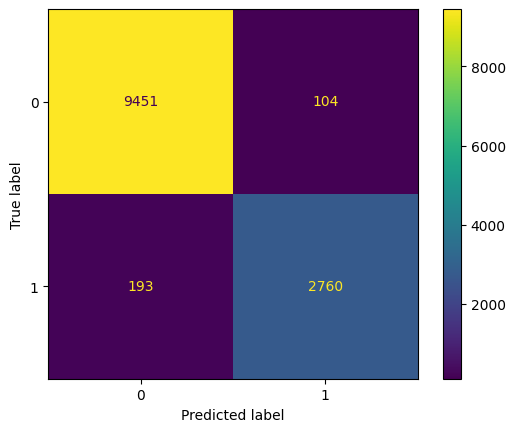

In [14]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(20,),(30,),(25,5),(15,)],'max_iter':[1000]} #(20,),(30,),(40,5),(35,10),(35,5),(35,),(30,5),(25,)


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)

mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [15]:
joblib.dump(mlpc, 'next_month_lapse_model.joblib')

['next_month_lapse_model.joblib']

## Scoring data

In [16]:
new_data = X_test.copy()
pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
new_data['index']=new_data.index
new_data = pd.merge(new_data,pol_names,on='index',how='left')
new_data.drop(columns=['index'],inplace=True)
model_file='next_month_lapse_model.joblib'
next_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next_model.feature_names_in_)].copy()
next_prediction = next_model.predict(score_data)
next_prob = next_model.predict_proba(score_data)

# Next 3 month lapse

In [16]:
X_train, X_test, Y_train, y_test=data_prep(data_s.copy(),'3month')

## Training model

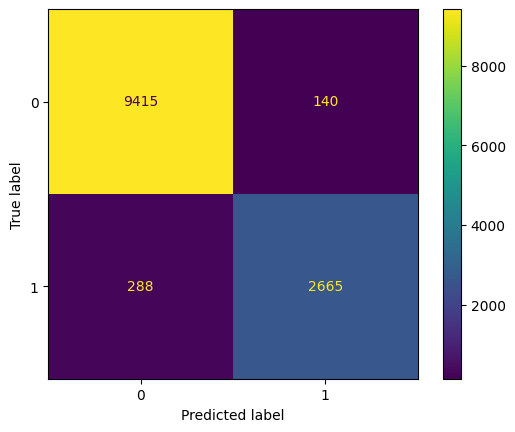

In [17]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(20,),(30,),(25,5),(15,)],'max_iter':[1000]} #(20,),(30,),(40,5),(35,10),(35,5),(35,),(30,5),(25,)


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)

mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [18]:
joblib.dump(mlpc, 'next_3month_lapse_model.joblib')

['next_3month_lapse_model.joblib']

## Scoring data

In [19]:
model_file='next_3month_lapse_model.joblib'
next3_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next3_model.feature_names_in_)].copy()
next3_prediction = next3_model.predict(score_data)
next3_prob = next3_model.predict_proba(score_data)


NameError: name 'new_data' is not defined

# Scored data

In [30]:
new_data['next month lapse prediction']=next_prediction
new_data['next month lapse prob']=next_prob[:,1]
new_data['next 3 month lapse prediction']=next3_prediction
new_data['next 3 month lapse prob']=next3_prob[:,1]
new_data.to_csv(path+'scored_data_nearftr.csv')

# Scoring data

In [ ]:
data=pd.DataFrame(pd.read_csv(path+"near_ftr_model_data.csv")).sample(5000)



In [ ]:
scale = StandardScaler()
data_s=data.copy()
scale_cols=['age', 'benefits_count', 'income',
       'premium','original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '# calls',
       '# calls contacted', 'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation', 'unemployment rate']
data_s[scale_cols] = scale.fit_transform(data_s[scale_cols])

feats1 = joblib.load('Models/next_3month_lapse_model.joblib')
feats2 = joblib.load('Models/next_month_lapse_model.joblib')
features=set(feats1.feature_names_in_)|set(feats2.feature_names_in_)

new_data = data_prep_scoring(data_s,features)

model_file='Models/next_month_lapse_model.joblib'
next_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next_model.feature_names_in_)].copy()
next_prediction = next_model.predict(score_data)
next_prob = next_model.predict_proba(score_data)
model_file='Models/next_3month_lapse_model.joblib'
next3_model = joblib.load(model_file)
score_data = new_data.loc[:, list(next3_model.feature_names_in_)].copy()
next3_prediction = next3_model.predict(score_data)
next3_prob = next3_model.predict_proba(score_data)

new_data['next month lapse prediction']=next_prediction
new_data['next month lapse prob']=next_prob[:,1]
new_data['next 3 month lapse prediction']=next3_prediction
new_data['next 3 month lapse prob']=next3_prob[:,1]
#new_data.to_csv(path+'scored_data_nearftr.csv')

# Viewing score data

## plot functions

In [1]:
#functions for plotting continous features
def plot_histogram_boxplot_kde(data, title="Data Distribution", x_label="Value"):
    """
    Generates a combined plot showing a histogram with KDE, a box plot,
    and summary statistics.

    Args:
        data (array-like): A list, numpy array, or pandas Series of numerical data.
        title (str, optional): The main title for the plot. Defaults to "Data Distribution".
        x_label (str, optional): The label for the x-axis. Defaults to "Value".
    """
    # Convert data to a pandas Series to easily handle potential NaNs and calculations
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Drop NaN values to avoid errors in plotting and calculations
    print('Number of NaN values to be dropped: ',data.isnull().sum())
    data = data.dropna()

    if data.empty:
        print("Warning: Input data is empty or contains only NaN values. Cannot generate plot.")
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics for display
    stats_text = (
        f"Statistics:\n"
        f"-----------\n"
        f"Count: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Set up the plot layout ---
    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    # Define the grid layout: 2 rows, 2 columns.
    # Top row for box plot, bottom row for histogram.
    # Right column for text.
    # Adjust width/height ratios for better spacing.
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           figure=fig, wspace=0.1, hspace=0.05) # Reduced space

    # Create axes for each part of the plot
    ax_hist = fig.add_subplot(gs[1, 0])        # Histogram/KDE at bottom-left
    ax_box = fig.add_subplot(gs[0, 0], sharex=ax_hist) # Box plot at top-left, sharing x-axis
    ax_text = fig.add_subplot(gs[:, 1])        # Text box spanning both rows on the right

    # --- Plot the data ---
    # 1. Histogram and KDE plot (using seaborn for convenience)
    #    'bins="auto"' lets seaborn/numpy choose a suitable number of bins.
    #    'kde=True' adds the Kernel Density Estimate.
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Density")

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1.5, label=f'Median ({median_val:.2f})')
    ax_hist.legend(loc='upper right') # Add legend to histogram plot

    # 2. Box plot
    #    Use seaborn's boxplot for consistency.
    #    'orient='h'' makes it horizontal.
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('') # Remove x-label as it's shared with histogram
    # Remove y-ticks and labels from boxplot for cleaner look
    ax_box.set_yticks([])
    ax_box.set_ylabel('') # Remove y-label

    # Remove ticks and labels from the top x-axis of the box plot
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False) # Remove ticks

    # 3. Statistics Text Box
    ax_text.axis('off') # Turn off the axis lines and ticks
    # Place the text in the center of the text axes
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))

    # --- Final Touches ---
    fig.suptitle(title, fontsize=16) # Add overall title
    # Adjust layout to prevent labels/titles overlapping
    # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    fig.subplots_adjust(top=0.92) # Adjust top margin for suptitle

#--------------------------------------------------------------------------------------------------------------------------------------------

# --- Helper function to plot distribution for a single category ---
# This adapts the logic from the previous function to draw on specific axes
def _plot_single_distribution(data, fig, ax,title="Distribution", x_label="Value"):
    """
    Helper function to draw histogram, KDE, box plot, and stats on a given Axes object
    by creating a nested GridSpec.

    Args:
        data (pd.Series): Numerical data for a single category (NaNs already handled).
        fig (matplotlib.figure.Figure): The main figure object.
        ax (matplotlib.axes.Axes): The main Axes object (from the outer grid)
                                   to draw this category's plot within.
        title (str): Title for this specific subplot.
        x_label (str): Label for the x-axis.
    """

    
  
    # Get the SubplotSpec from the parent Axes object
    ss = ax.get_subplotspec()
    # Turn off the axis frame/ticks for the original 'ax' as its space will be managed by the nested GridSpec
    ax.axis('off')

    if data.empty:
        # If data is empty, add text to the original Axes location
        ax.text(0.5, 0.5, "No data for this category",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=10, color='grey')
        ax.set_title(title, fontsize=10) # Set title on the original Axes
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics
    stats_text = (
        f"N: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"StdDev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Create inset axes within the main 'ax' space using its SubplotSpec ---
    gs_inset = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ss, # Use the SubplotSpec here
                                                width_ratios=[4, 1], height_ratios=[1, 4],
                                                wspace=0.05, hspace=0.05)

    # Create the actual Axes using the main figure and the nested GridSpec indices
    ax_hist = fig.add_subplot(gs_inset[1, 0]) # Histogram at bottom-left
    ax_box = fig.add_subplot(gs_inset[0, 0], sharex=ax_hist) # Box plot at top-left
    ax_text = fig.add_subplot(gs_inset[:, 1]) # Text box on the right

    # --- Plot the data ---
    # 1. Histogram and KDE
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label, fontsize=9) # Slightly smaller font for subplot labels
    ax_hist.set_ylabel("Density", fontsize=9)
    ax_hist.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median ({median_val:.2f})')
    ax_hist.legend(fontsize='x-small', loc='upper right') # Smaller legend

    # 2. Box plot
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])
    ax_box.set_ylabel('')
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False)

    # 3. Statistics Text Box
    ax_text.axis('off')
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=8, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))

    # Set the title for the specific subplot (category) on the original Axes container
    ax.set_title(title, fontsize=10)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# --- Main function to create the grid plot ---
def plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions"):
    """
    Generates a grid of distribution plots (hist, KDE, boxplot, stats)
    for numerical data grouped by a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_col (str): The name of the column with numerical data.
        category_col (str): The name of the column with categorical data.
        main_title (str, optional): The main title for the entire figure.
                                    Defaults to "Grouped Distributions".
    """

    if category_col == 'none':
        
        plot_histogram_boxplot_kde(df[value_col], title=f"Distribution of {value_col}", x_label=value_col)

    else:

        # Check if columns exist
        if value_col not in df.columns:
            print(f"Error: Value column '{value_col}' not found in DataFrame.")
            return
        if category_col not in df.columns:
            print(f"Error: Category column '{category_col}' not found in DataFrame.")
            return

        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs in category column
        # Sort categories for consistent plot order
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # --- Determine grid layout ---
        # Aim for a layout that's roughly square
        ncols = math.ceil(math.sqrt(n_categories))
        nrows = math.ceil(n_categories / ncols)

        # --- Create figure and subplots ---
        # Adjust figsize based on grid size for better readability
        # Increased base size slightly for better spacing within subplots
        fig_width = ncols * 5.5
        fig_height = nrows * 4.5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)

        # Flatten axes array for easy iteration
        axes_flat = axes.flatten()

        # --- Plot data for each category ---
        for i, category in enumerate(categories):
            ax = axes_flat[i]
            # Filter data for the current category, dropping NaNs in the value column
            category_data = df[df[category_col] == category][value_col].dropna()

            # Call the helper function to plot on the current axes
            # Pass the main 'fig' object as well
            _plot_single_distribution(category_data, fig, ax, # Pass fig and ax
                                      title=f"{category}", # Simpler title, category name only
                                      x_label=value_col)

        # --- Clean up unused subplots ---
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off') # Hide unused axes

        # --- Final Touches ---
        # Add a more descriptive main title including column names
        full_main_title = f"{main_title}: {value_col} by {category_col}"
        fig.suptitle(full_main_title, fontsize=16, y=1.0) # Adjust title position slightly
        # Use tight_layout first, then adjust spacing if needed
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to prevent overlap and make space for title/labels
        # plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3) # Fine-tune spacing if tight_layout isn't enough

    plt.show()

In [2]:
#bar comparison
def bar_comp(df,category, split):
    
    props=df.groupby(split)[category].value_counts(normalize=True).rename('proportion').reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=props,
        x=category,
        y='proportion',
        hue=split,
        palette='viridis')  
    
    # Set the title and labels for clarity.
    plt.title(f'Proportion of {category} by {split}', fontsize=16)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.legend(title=split)

    # Add annotations to the bars to show the exact proportion.
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout() # Adjust layout to make room for the labels.
    plt.show()





## Views

In [11]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/NearFuture/"
scored_data=pd.DataFrame(pd.read_csv(path+"scored_data_nearftr.csv"))

data_o=pd.DataFrame(pd.read_csv(path+"near_ftr_model_data.csv"))

In [ ]:
data = multi_data_ops(file_list=[],df1=scored_data, df2=data_o)
data.df_merged=data.merging(on='policy_name', how='inner', df_left=data.df1, df_right=data.df2,col_left=['policy_name','next month lapse prediction', 'next month lapse prob','next 3 month lapse prediction', 'next 3 month lapse prob'], col_right=['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation',
           'unemployment rate','policy_name'])
data.df_merged


In [22]:
for t in ['next month lapse prob', 'next 3 month lapse prob']:
    ceilings = [0.0, 0.1,0.2,0.3001,0.4,0.5,0.6,0.7,0.8,0.9,1.05]
    bins=[f'{math.floor((n-0.1)*10)/10} - {math.floor(n*10)/10}' for n in ceilings[1:]]

    data.df_merged[t+' band'] = pd.cut(data.df_merged[t],bins=ceilings, labels=bins,right=False)

In [105]:
target='next 3 month lapse'

In [74]:
value_col= target+' prob'
plot_grouped_distributions(data.df_merged, value_col, category_col='lapse_flag',cat_list = [], main_title="Grouped Distributions")

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001568ED6F420> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000156DA316660> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

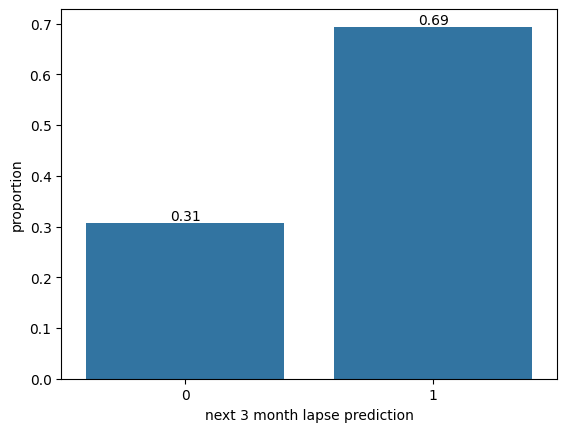

In [98]:

sns.barplot(data=next_lapse_pred_df['next 3 month lapse prediction'].value_counts(normalize=True).rename('proportion').reset_index(),x='next 3 month lapse prediction',y='proportion')
for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

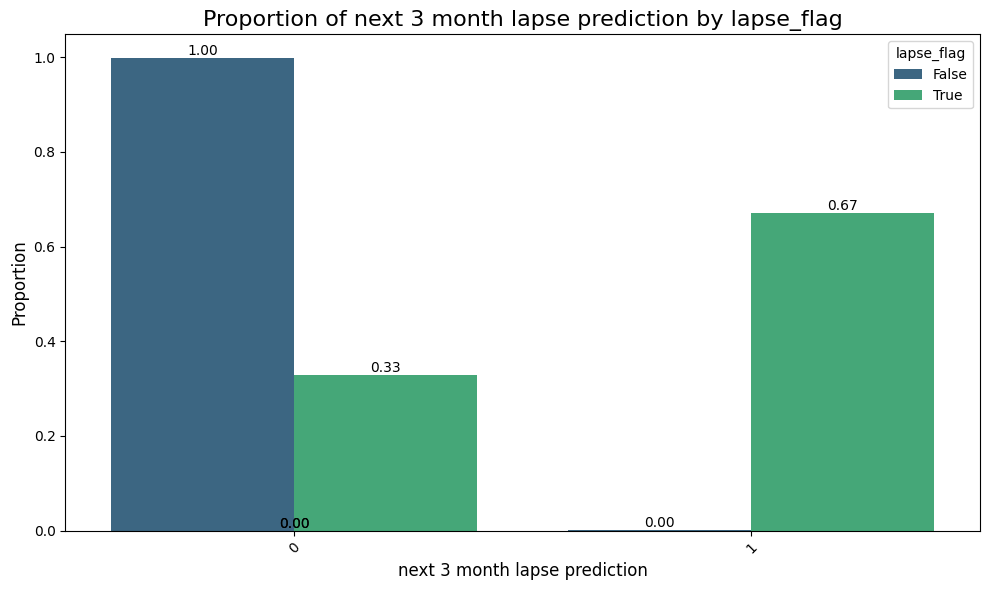

In [106]:
cat=  target+' prediction'
split='lapse_flag' 
bar_comp(data.df_merged,category=cat,split=split)

In [27]:
data.df_merged.columns

Index(['policy_name', 'next month lapse prediction', 'next month lapse prob',
       'next 3 month lapse prediction', 'next 3 month lapse prob', 'age',
       'benefits_count', 'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'optionality', 'premium',
       'original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium', 'lapse_flag',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '1 month ago payment',
       '2 month ago payment', '3 month ago payment', '4 month ago payment',
       '5 month ago payment', '6 month ago payment', '# calls',
       '# calls contacted'

In [107]:
gbcol =target+' prob band'
df = DataPreparation(df=data.df_merged.copy())
df.aggregation(groupby_cols=[gbcol],cat_cols=[],agg_dict_not_cat_cols={'lapses': pd.NamedAgg(column='lapse_flag', aggfunc='sum'),'total policies': pd.NamedAgg(column='lapse_flag', aggfunc='count')})
df.agg_df['actual lapse rate'] = df.agg_df['lapses']/df.agg_df['total policies']
df.agg_df

C:\Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package\data_preparation.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(groupby_cols).agg(**agg_dict).reset_index()


,next 3 month lapse prob band,lapses,total policies,actual lapse rate
0,0.0 - 0.1,695,10171,0.068332
1,0.1 - 0.2,95,138,0.688406
2,0.2 - 0.3,51,59,0.864407
3,0.3 - 0.4,57,66,0.863636
4,0.4 - 0.5,73,77,0.948052
5,0.5 - 0.6,56,57,0.982456
6,0.6 - 0.7,47,50,0.940000
7,0.7 - 0.8,60,63,0.952381
8,0.8 - 0.9,93,99,0.939394
9,0.9 - 1.0,1726,1728,0.998843


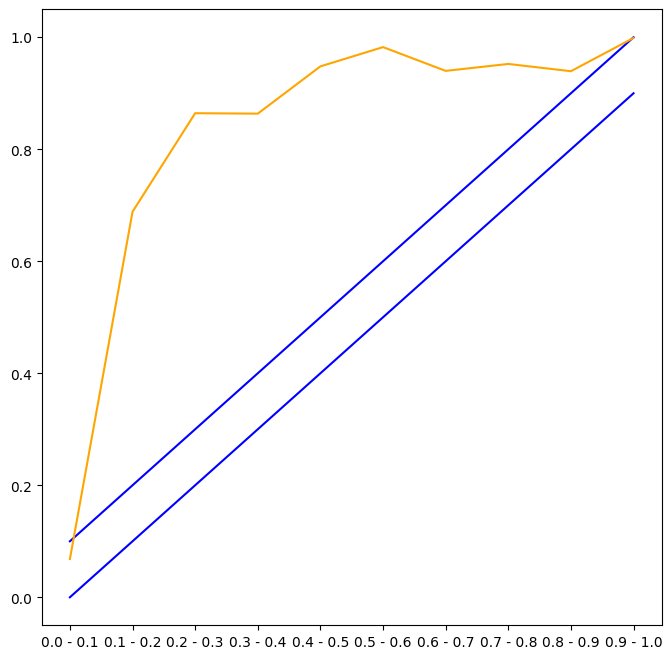

In [108]:
plt.figure(figsize=(8, 8))
plt.plot(bins,[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],color='blue')
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],color='blue')
plt.plot(df.agg_df['actual lapse rate'],color='orange')

plt.show()

In [82]:
df_scores = data.df_merged
df_scores

,policy_name,next month lapse prediction,next month lapse prob,next 3 month lapse prediction,next 3 month lapse prob,age,benefits_count,education,gender,income,...,# calls,# calls contacted,res_code_other_sum,res_code_payment_sum,res_code_sale_sum,inflation,unemployment rate,next month lapse prob band,next 3 month lapse prob band,cover_start_date
0,MWL005828689,0,0.001518,0,3.331491e-07,29,2.0,Matric,Female,14000.0,...,4.0,2.0,0.0,1.0,3.0,4.7,27.125,0.0 - 0.1,0.0 - 0.1,2018-08-01
1,MWL000292019,0,0.000529,0,8.119774e-08,40,1.0,Postgraduate Degree,Male,30000.0,...,0.0,0.0,0.0,0.0,0.0,6.4,26.725,0.0 - 0.1,0.0 - 0.1,2016-06-01
2,MWL007262272,1,0.911117,0,4.055740e-03,28,2.0,Matric,Female,40000.0,...,0.0,0.0,0.0,0.0,0.0,3.3,29.175,0.9 - 1.0,0.0 - 0.1,2020-04-01
3,MWL000568708,1,0.999947,0,6.578874e-02,31,1.0,Matric,Male,30000.0,...,21.0,3.0,0.0,4.0,17.0,6.4,26.725,0.9 - 1.0,0.0 - 0.1,2016-11-01
4,MWL008545455,0,0.005459,0,2.550719e-06,40,8.0,Matric,Female,40000.0,...,0.0,0.0,0.0,0.0,0.0,6.9,33.500,0.0 - 0.1,0.0 - 0.1,2022-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12503,ML22-0007560,1,0.999991,0,1.730770e-01,24,1.0,4 year Degree,Female,23000.0,...,19.0,0.0,0.0,0.0,19.0,6.0,32.375,0.9 - 1.0,0.1 - 0.2,2023-01-01
12504,ML23-0107732,1,0.999998,1,5.065325e-01,54,1.0,Matric + 3 year Diploma,Male,15239.0,...,2.0,0.0,0.0,0.0,2.0,6.0,32.375,0.9 - 1.0,0.5 - 0.6,2023-12-01
12505,ML23-0015137,1,1.000000,1,9.876372e-01,37,1.0,Matric + 3 year Diploma,Female,20000.0,...,4.0,0.0,0.0,0.0,4.0,6.0,32.375,0.9 - 1.0,0.9 - 1.0,2023-04-01
12506,ML24-0271085,1,0.999971,1,9.999783e-01,24,2.0,Matric,Male,15000.0,...,17.0,1.0,0.0,0.0,17.0,4.4,32.600,0.9 - 1.0,0.9 - 1.0,2024-11-01


C:\Users\E1005279\AppData\Local\Temp\ipykernel_13756\3735807661.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df= data.df_merged[['policy_name',band1,band2]].groupby([band1,band2]).count().unstack()


<Axes: xlabel='next 3 month lapse prob band'>

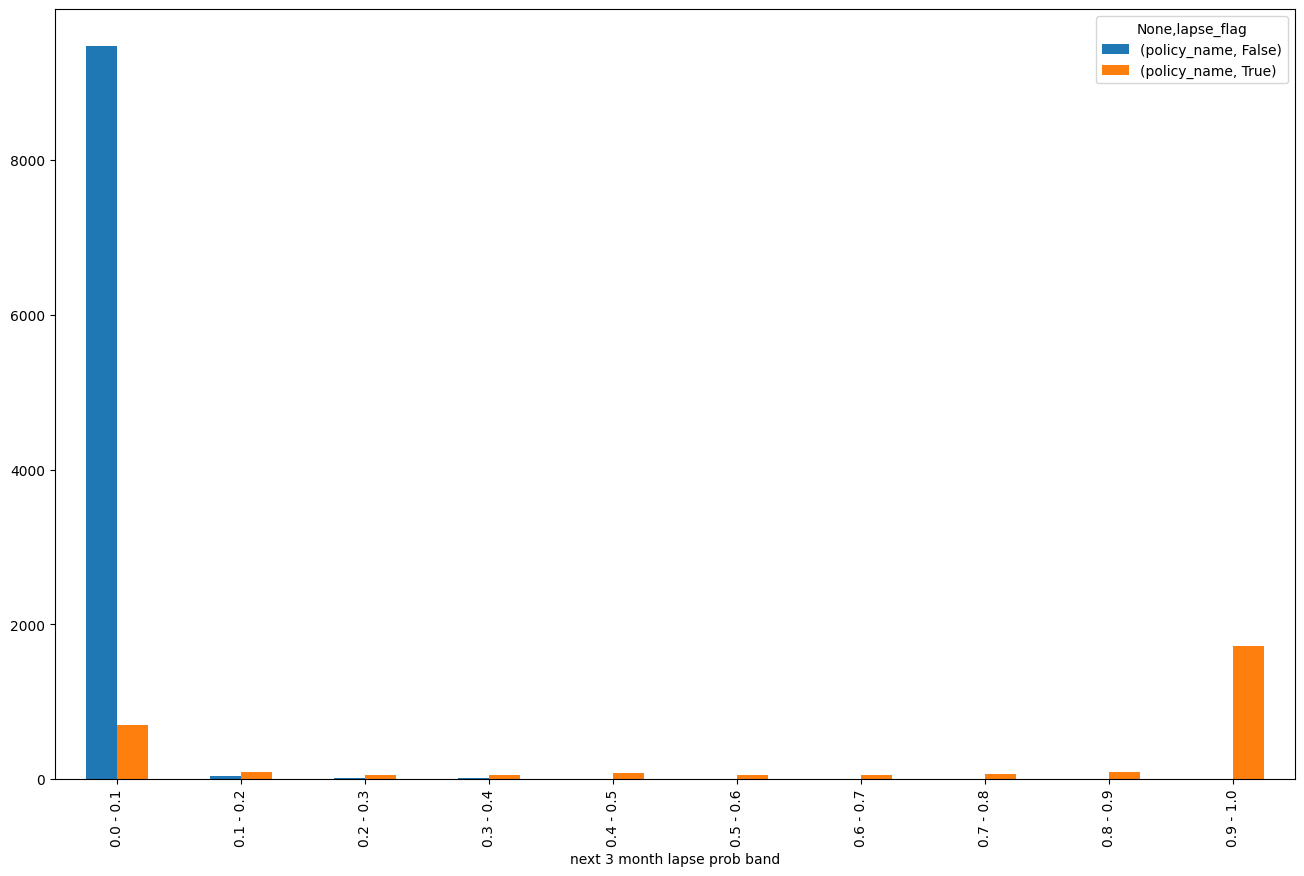

In [109]:
band1=target+' prob band'
band2='lapse_flag'

new_df= data.df_merged[['policy_name',band1,band2]].groupby([band1,band2]).count().unstack() 
new_df.plot(kind='bar',figsize=(16,10))

[]

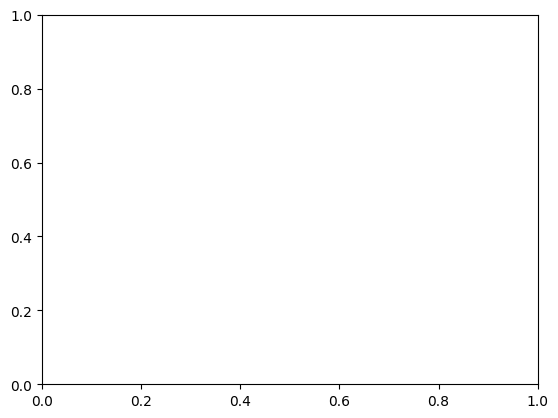

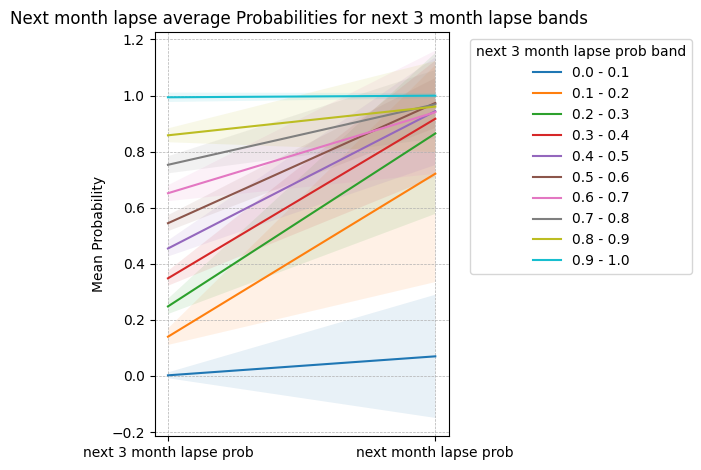

In [104]:
def stats_nums(data):
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)
    return [mean_val,median_val,std_dev,q1,q3,iqr]

band_name ='next 3 month lapse prob band'
bands=['0.0 - 0.1','0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4','0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7',  '0.7 - 0.8', '0.8 - 0.9','0.9 - 1.0']
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 10))))
fig, ax = plt.subplots()

for i in range(len(bands)):
    df_pbc = data.df_merged[data.df_merged[band_name]== bands[i]].copy()
    stats = {}
    y=[]
    lower=[]
    upper=[]

    t = 'next 3 month lapse'
    stats[t+' prob'] = stats_nums(df_pbc[t+' prob'])
    y.append(stats[t+' prob'][0])
    lower.append(stats[t+' prob'][0]-stats[t+' prob'][2])
    upper.append(stats[t+' prob'][0]+stats[t+' prob'][2])
    t = 'next month lapse'
    stats[t+' prob'] = stats_nums(df_pbc[t+' prob'])
    y.append(stats[t+' prob'][0])
    lower.append(stats[t+' prob'][0]-stats[t+' prob'][2])
    upper.append(stats[t+' prob'][0]+stats[t+' prob'][2])
    

 
    ax.plot(stats.keys(),y, label=bands[i])
    ax.fill_between(stats.keys(), lower, upper, alpha=.1)

ax.set_title('Next month lapse average Probabilities for next 3 month lapse bands ')
ax.set_ylabel('Mean Probability')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title=band_name, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.plot()

In [ ]:
data_date=pd.DataFrame(pd.read_csv(path+"near_ftr_lapse_data.csv"))

data.df_merged = data.df_merged.merge(data_date[['policy_name', 'cover_start_date']], on='policy_name',how='inner')
data.df_merged['cover_start_date'] =pd.to_datetime(data.df_merged['cover_start_date'])

In [67]:
data.df_merged[target+ ' prediction'].sum()

2864

C:\Users\E1005279\AppData\Local\Temp\ipykernel_13756\407658260.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='cohort', bbox_to_anchor=(1.05, 1), loc='upper left')


[]

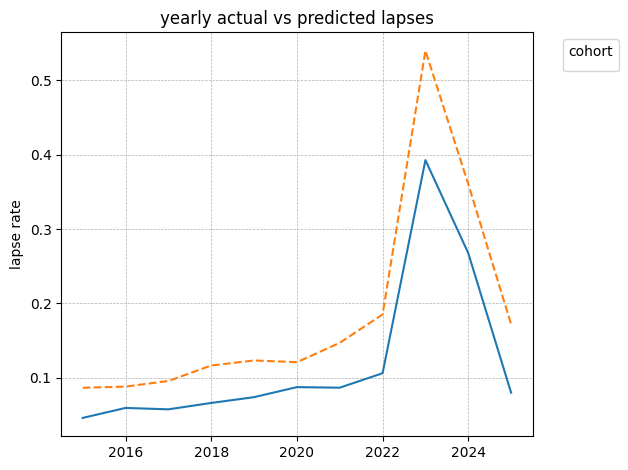

In [83]:
fig, ax = plt.subplots()
y_pred = []
y_act=[]
x=[ 2015, 2016,2017,2018, 2019,2020, 2021, 2022, 2023, 2024, 2025]
for year in [ 2015, 2016,2017,2018, 2019,2020, 2021, 2022, 2023, 2024, 2025]:
    policies=data.df_merged[(data.df_merged['cover_start_date'].dt.year==year)]['policy_name']
    cohort = data.df_merged[data.df_merged['policy_name'].isin(policies)]

    
    y_pred.append(cohort[target+ ' prediction'].sum()/len(policies))
    y_act.append(cohort['lapse_flag'].sum()/len(policies))

ax.plot(x,y_pred)
ax.plot(x,y_act, linestyle='dashed')
ax.set_title('yearly actual vs predicted lapses') #vs predicted
ax.set_ylabel('lapse rate')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title='cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.plot()
